In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('kobe.csv')
# Массив с кегла. Отправлю им посмотреть результат
data_check = pd.read_csv('kobe_test.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [4]:
data_check.describe()

,shot_id,shot_made_flag
count,5000.00000,5000.0
mean,15456.06940,0.5
std,8867.58899,0.0
min,1.00000,0.5
25%,7800.50000,0.5
50%,15414.00000,0.5
75%,23210.25000,0.5
max,30694.00000,0.5


**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

In [5]:
data_full = data.dropna()

In [6]:
data_full[data_full.columns[:10]].head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3


In [7]:
data_full[data_full.columns[10:20]].head()

,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id
1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747
2,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747
3,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747
4,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747
5,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747


In [8]:
data_full[data_full.columns[20:]].head()

,team_name,game_date,matchup,opponent,shot_id
1,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


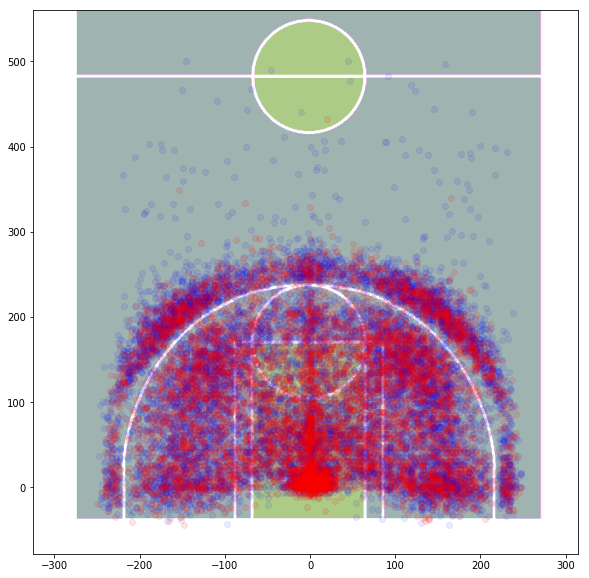

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
img = plt.imread('field.png')
ax = ax.imshow(img, extent=[-325, 315, -45, 560])
ax = plt.scatter(data_full[(data_full['shot_made_flag'] == 0) & (data_full['loc_y'] <= 500)].loc_x,
                 data_full[(data_full['shot_made_flag'] == 0) & (data_full['loc_y'] <= 500)].loc_y,
                 alpha=0.08, color='blue', marker='o')
ax = plt.scatter(data_full[(data_full['shot_made_flag'] == 1) & (data_full['loc_y'] <= 500)].loc_x,
                 data_full[(data_full['shot_made_flag'] == 1) & (data_full['loc_y'] <= 500)].loc_y,
                 alpha=0.1, color='red', marker='o')
plt.show()

На тепловой карте отчетлево видно рабиение на зоны. Они уже любезно описаны составителем датафрейма в переменных shot_zone_area, shot_zone_basic, shot_zone_range. Сравним резултативность бросков в этих зонах.	

Для удобства, напишем функцию, которая будет подготавливать категориальные данные к анализу и считать параметр accuracy внутри групп:

In [10]:
def catplot_group(df, col):
    data_grouped = df.groupby(by=col).aggregate(['count', 'sum'])
    data_grouped = data_grouped['shot_made_flag']
    data_grouped['accuracy'] = data_grouped.apply(lambda x: x['sum'] / x['count'], axis=1)
    data_grouped = data_grouped.reset_index()
    return data_grouped

Добавим функцию - рисовальщик

In [11]:
def catplot_draw(plot_data, col, ascending=True):
    if ascending == True:
        sns.catplot(x=col, y='accuracy', data=plot_data, kind='bar',
             aspect=2.5, order=plot_data.sort_values(by='accuracy', ascending=False).iloc[:,0].tolist())
    else:
        sns.catplot(x=col, y='accuracy', data=plot_data, kind='bar', aspect=2.5)

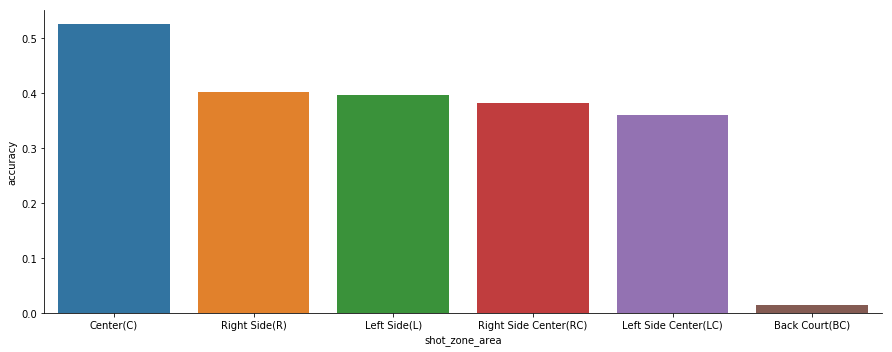

In [12]:
catplot_draw(catplot_group(data_full, 'shot_zone_area'), 'shot_zone_area')

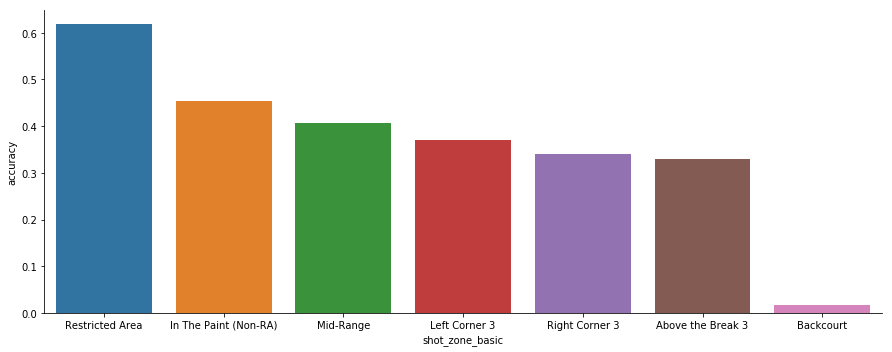

In [13]:
catplot_draw(catplot_group(data_full, 'shot_zone_basic'), 'shot_zone_basic')

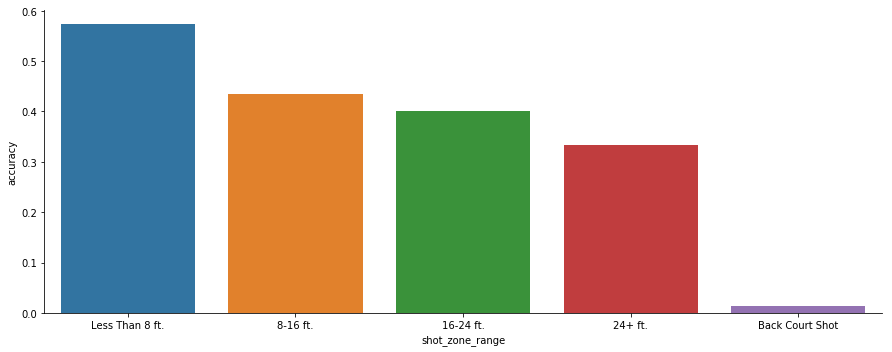

In [14]:
catplot_draw(catplot_group(data_full, 'shot_zone_range'), 'shot_zone_range')

Разбор графиков подтверждает увиденное на тепловой карте. Наиболее результативные броски происходят из под кольца и из [запрещенной зоны](https://en.wikipedia.org/wiki/Key_(basketball)#Restricted_area_arc)

Оценим результативность бросков в зависимости от оставшегося времени

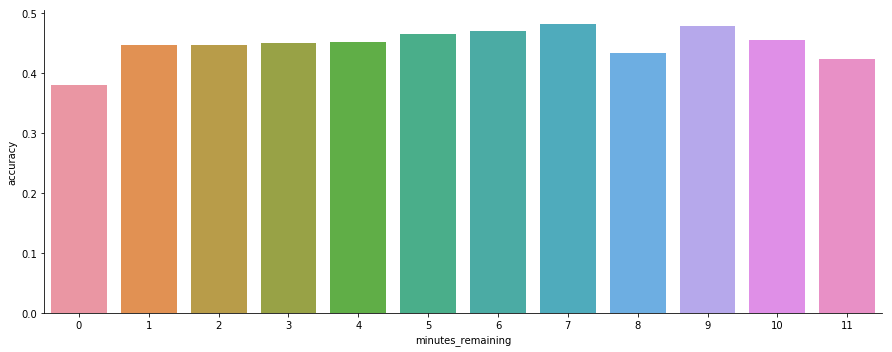

In [15]:
catplot_draw(catplot_group(data_full, 'minutes_remaining'), 'minutes_remaining', False)

Броски "на удачу" - не проходят. Результативность в начале чертверти выше, чем в конце. Количество бросков к концу четверти возрастает. 

Оценим, как зависит дистанция броска от оставшегося времени и каков результат этого броска

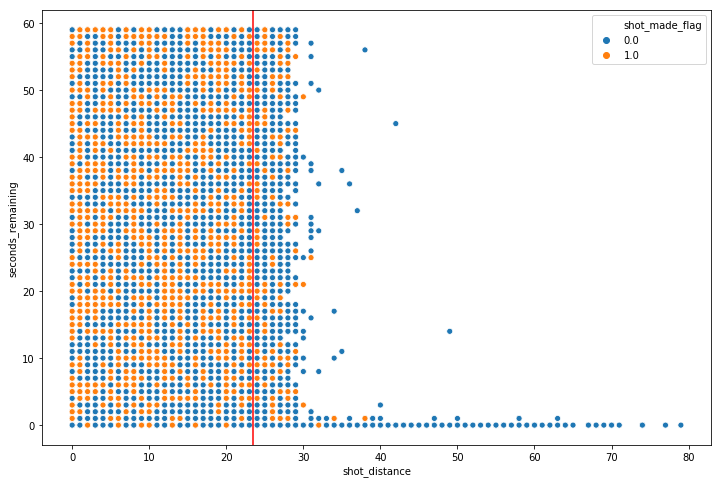

In [16]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='shot_distance', y='seconds_remaining', data=data_full, hue='shot_made_flag')
plt.axvline(23.5, color='red')

Распределение, конечно, похоже на шум, но отчетливо видно, что игрок не любит рисковать. Напомню, что 3х-очковая зона это 23 фута 9 дюймов (7.24 метра).

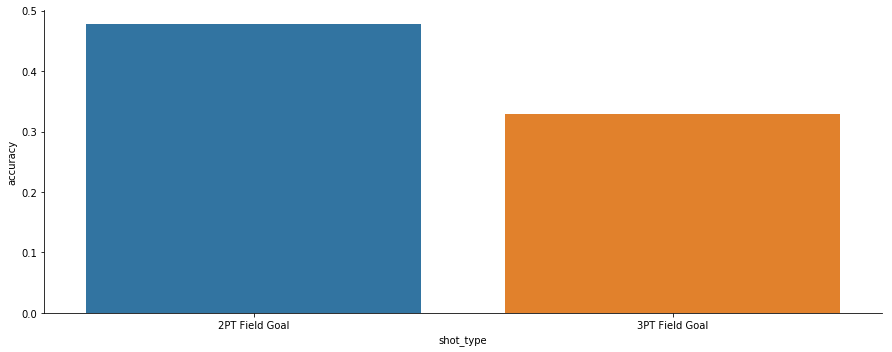

In [17]:
catplot_draw(catplot_group(data_full, 'shot_type'), 'shot_type')

Странно, что в данных и на тепловой карте не видно штрафных.

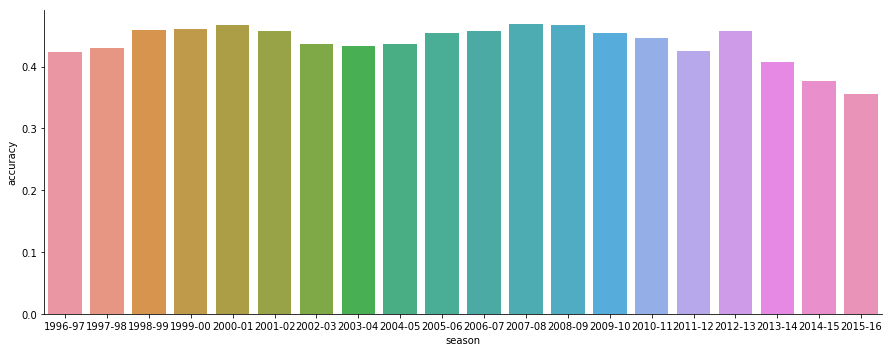

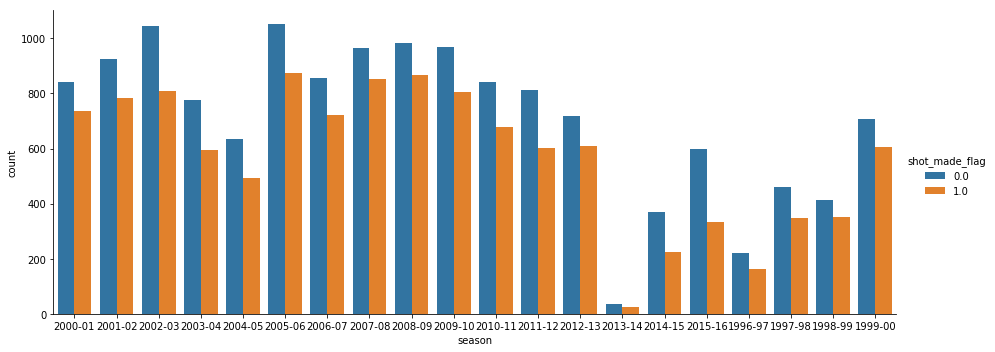

In [18]:
catplot_draw(catplot_group(data_full, 'season'), 'season', False)
sns.catplot(x='season', hue='shot_made_flag', data=data_full, kind='count', aspect=2.5, col_order=data_full.sort_values(by='game_date')['season'].unique().tolist())

Интересно, в последних сезонах упала точность. А в 2013-14 резко сократилось количество бросков.
Гугление указывает на серьезную травму - [разрыв связки](https://en.wikipedia.org/wiki/Kobe_Bryant#Injury-plagued_years_(2013%E2%80%932015))

Посмотрим на результативность в зависимости от типа бросков

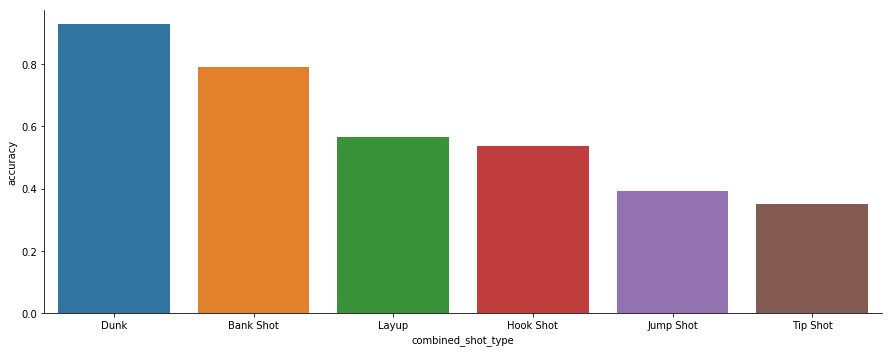

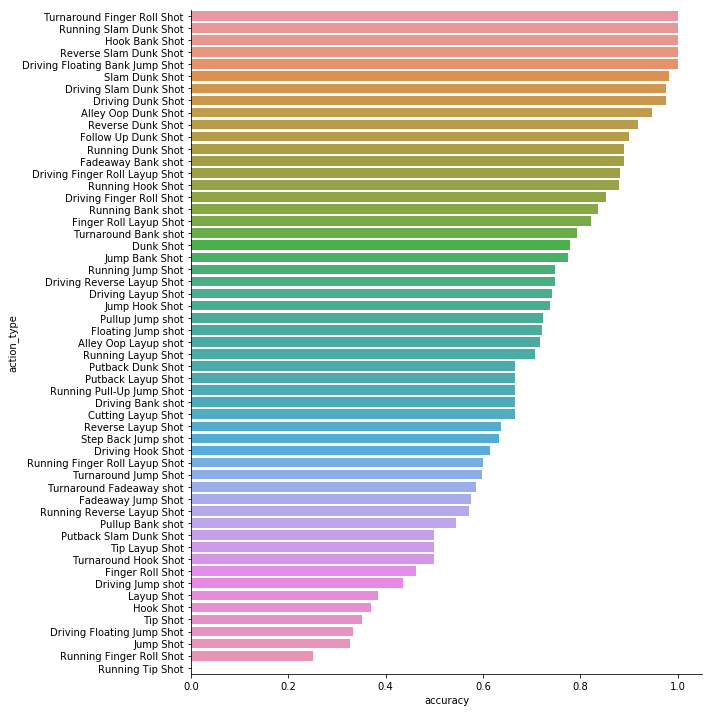

In [19]:
catplot_draw(catplot_group(data_full, 'combined_shot_type'), 'combined_shot_type')
plot_action_type = catplot_group(data_full, 'action_type')
sns.catplot(y='action_type', x='accuracy', data=plot_action_type, kind='bar',
             height= 10, order=plot_action_type.sort_values(by='accuracy', ascending=False).iloc[:,0].tolist())

Вау, 100% результативность в некоторых видах бросков

Изучим результативность в зависимости от оппонента.

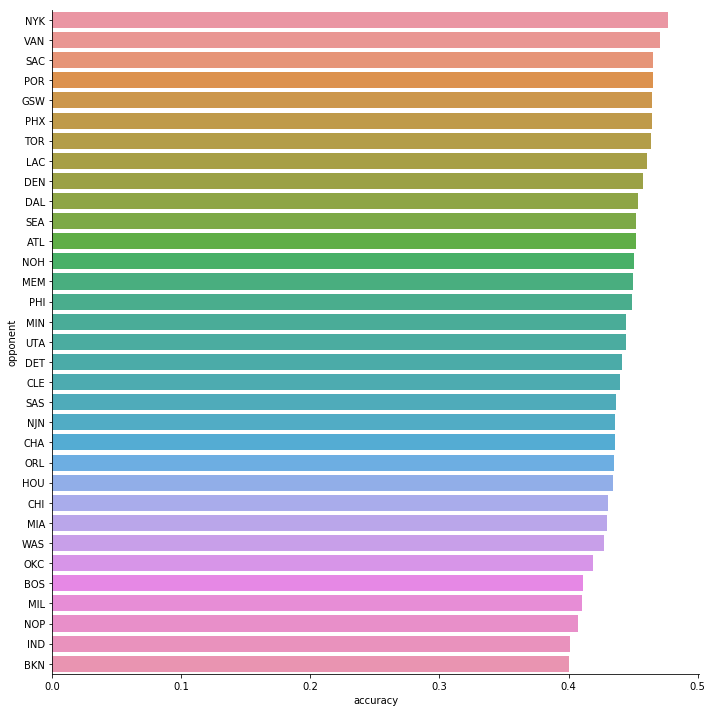

In [20]:
plot_action_type = catplot_group(data_full, 'opponent')
sns.catplot(y='opponent', x='accuracy', data=plot_action_type, kind='bar',
             height= 10, order=plot_action_type.sort_values(by='accuracy', ascending=False).iloc[:,0].tolist())

У нас осталась необработанной переменная с датой. Приведем её к стандарту datetime и добавим фичи с днем недели и месяцем.

In [21]:
data_full['weekday'] = data_full.apply(lambda x: datetime.strftime(datetime.strptime(str(x['game_date']), '%Y-%m-%d'), '%a'), axis=1)
data_full['month'] = data_full.apply(lambda x: datetime.strftime(datetime.strptime(str(x['game_date']), '%Y-%m-%d'), '%b'), axis=1)

/home/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


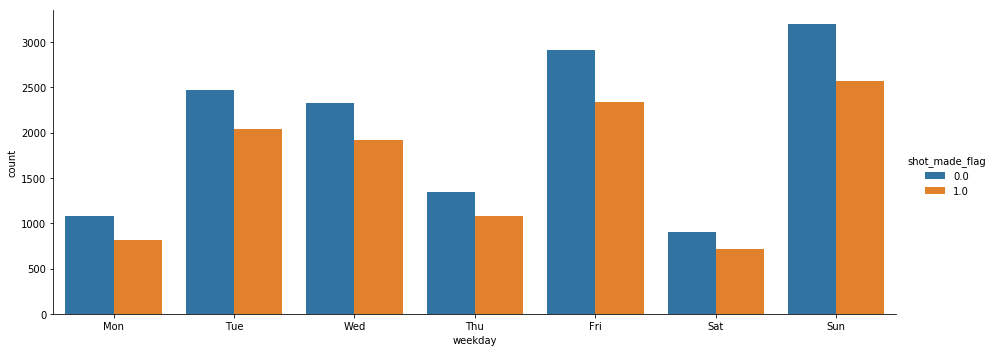

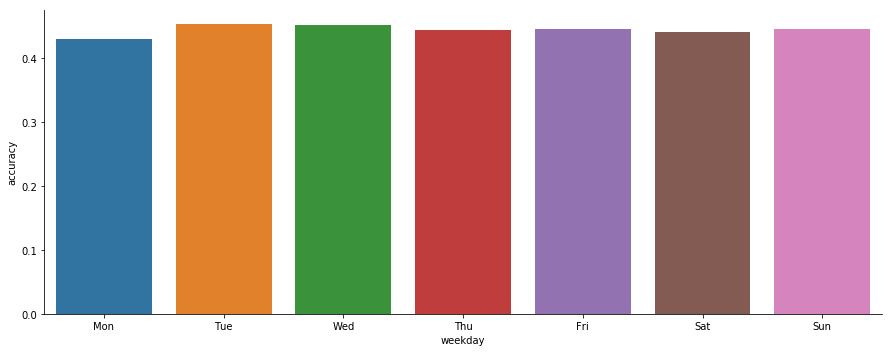

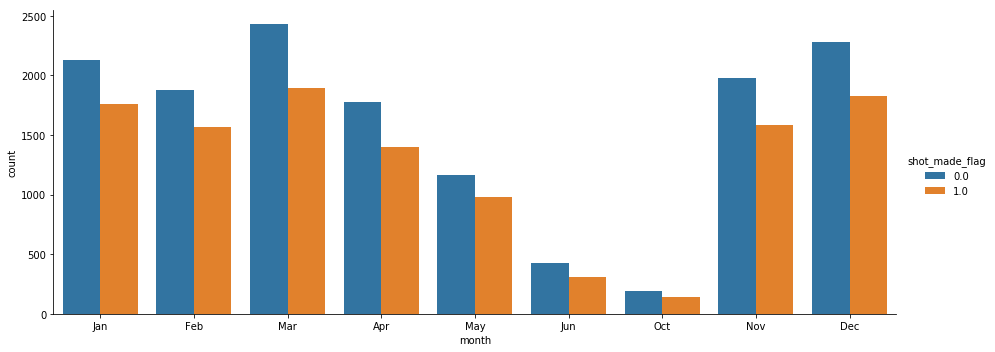

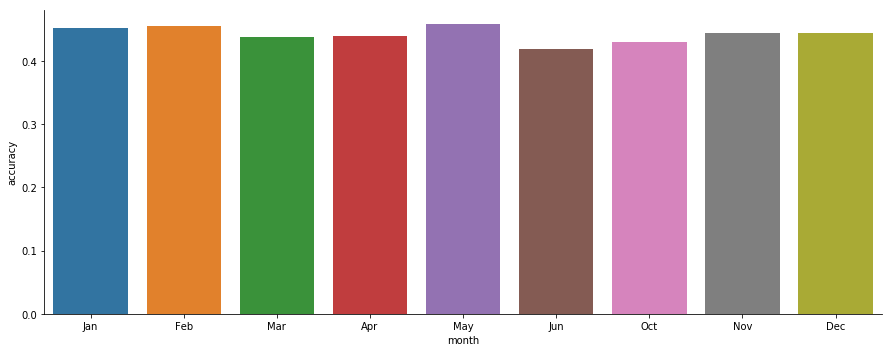

In [22]:
sns.catplot(x='weekday', hue='shot_made_flag', data=data_full, kind='count', aspect=2.5, order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plot_weekday = catplot_group(data_full, 'weekday')
sns.catplot(x='weekday', y='accuracy', data=plot_weekday, kind='bar',
             aspect=2.5, order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

sns.catplot(x='month', hue='shot_made_flag', data=data_full, kind='count', aspect=2.5,
             order=['Jan','Feb','Mar','Apr','May','Jun', 'Oct', 'Nov', 'Dec'])
plot_month = catplot_group(data_full, 'month')
sns.catplot(x='month', y='accuracy', data=plot_month, kind='bar',
             aspect=2.5, order=['Jan','Feb','Mar','Apr','May','Jun', 'Oct', 'Nov', 'Dec'])

Думаю, с разведкой можно закончить. Что мы имеем:
- Тавма в 2013 году, которая серьезно отразилась на результативности и количестве бросков в последующих сезонах
- Игрок не "лихачит" и выполняет рискованные броски только на последних секундах матча
- Игрок предпочитает борьбу под кольцом, и показывает высокую результативность в зоне за кольцом
- Нет значимых различий (визуально) между левыми и правыми бросками
- Аккуратность бросков слабо зависит от дней недели, месяцев и участии в плейофф

### Начнем готовить датафрейм для обучения моделей

Сперва уберем все лишнее

In [23]:
data = pd.read_csv('kobe.csv')

In [24]:
data[['lat', 'loc_x', 'loc_y', 'lon']].corr()

,lat,loc_x,loc_y,lon
lat,1.000000,0.016217,-1.000000,0.016217
loc_x,0.016217,1.000000,-0.016217,1.000000
loc_y,-1.000000,-0.016217,1.000000,-0.016217
lon,0.016217,1.000000,-0.016217,1.000000


In [25]:
data = data.drop(columns=['lat', 'lon', 'team_id', 'team_name'])

Добавим недели и месяцы

In [26]:
data['weekday'] = data.apply(lambda x: datetime.strftime(datetime.strptime(str(x['game_date']), '%Y-%m-%d'), '%a'), axis=1)
data['month'] = data.apply(lambda x: datetime.strftime(datetime.strptime(str(x['game_date']), '%Y-%m-%d'), '%b'), axis=1)

Теперь напишем функцию, которая заменяет все категориальные переменные на параметр accuracy, полученный при группировки этих переменных.

In [27]:
def grouper(df, col):
    data_grouped = df.groupby(by=col).aggregate(['count', 'sum'])
    data_grouped = data_grouped['shot_made_flag']
    data_grouped['accuracy'] = data_grouped.apply(lambda x: x['sum'] / x['count'], axis=1)
    data_grouped = data_grouped.reset_index()
    group_id = {}
    for each in data_grouped[col]:
        group_id[each] = data_grouped[data_grouped[col] == each].iloc[0, 1:].tolist()
    df[col] = df.apply(lambda x: group_id[x[col]][2], axis=1)
    
    return df

In [28]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,loc_x,loc_y,minutes_remaining,period,playoffs,season,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id,weekday,month
0,Jump Shot,Jump Shot,10,20000012,167,72,10,1,0,2000-01,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,1,Tue,Oct
1,Jump Shot,Jump Shot,12,20000012,-157,0,10,1,0,2000-01,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR,2,Tue,Oct
2,Jump Shot,Jump Shot,35,20000012,-101,135,7,1,0,2000-01,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,3,Tue,Oct
3,Jump Shot,Jump Shot,43,20000012,138,175,6,1,0,2000-01,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,4,Tue,Oct
4,Driving Dunk Shot,Dunk,155,20000012,0,0,6,2,0,2000-01,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR,5,Tue,Oct


In [29]:
col_to_prepare_list = ['action_type', 'combined_shot_type',
       'minutes_remaining', 'period', 'playoffs', 'season',
       'seconds_remaining', 'shot_distance', 'shot_type',
       'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'opponent', 'weekday', 'month']

In [30]:
# И снова уберем лишнее
data.index = data.shot_id
data = data.drop(columns=['game_event_id', 'game_id', 'matchup', 'game_date', 'shot_id'])

In [31]:
for column in col_to_prepare_list:
    data = grouper(data, column)
data.head()

/home/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,weekday,month
shot_id,,,,,,,,,,,,,,,,,,
1,0.326913,0.391071,167,72,0.454950,0.465672,0.44642,0.466667,0.459330,0.400837,NaN,0.477348,0.401658,0.406286,0.401766,0.46517,0.452487,0.430303
2,0.326913,0.391071,-157,0,0.454950,0.465672,0.44642,0.466667,0.434368,0.426955,0.0,0.477348,0.396871,0.406286,0.435484,0.46517,0.452487,0.430303
3,0.326913,0.391071,-101,135,0.481876,0.465672,0.44642,0.466667,0.497619,0.390558,1.0,0.477348,0.361177,0.406286,0.401766,0.46517,0.452487,0.430303
4,0.326913,0.391071,138,175,0.469965,0.465672,0.44642,0.466667,0.461728,0.369527,0.0,0.477348,0.382567,0.406286,0.401766,0.46517,0.452487,0.430303
5,0.976654,0.928030,0,0,0.469965,0.448802,0.44642,0.466667,0.467933,0.634766,1.0,0.477348,0.525556,0.618004,0.573120,0.46517,0.452487,0.430303


Исходный датафрейм обработан. 
Делаем сэмплинг

In [32]:
data_full = data.dropna()
data_train = data_full.sample(20557, random_state=42)
train_shots = set(data_train.index.unique())
data_test = data_full[~data_full.index.isin(train_shots)]

### Начинаем обучение

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib

In [34]:
X_train = data_train.drop(columns='shot_made_flag')
y_train = data_train['shot_made_flag']

X_test = data_test.drop(columns='shot_made_flag')
y_test = data_test['shot_made_flag']

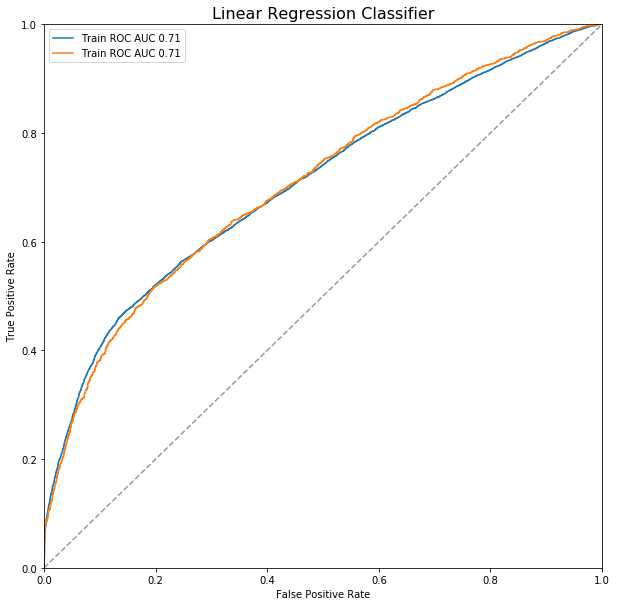

In [35]:
lm = LinearRegression().fit(X=X_train, y=y_train)

y_train_predict = lm.predict(X_train)
y_test_predict = lm.predict(X_test)
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Train ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear Regression Classifier', size=16)
plt.legend(loc='upper left')
plt.show()

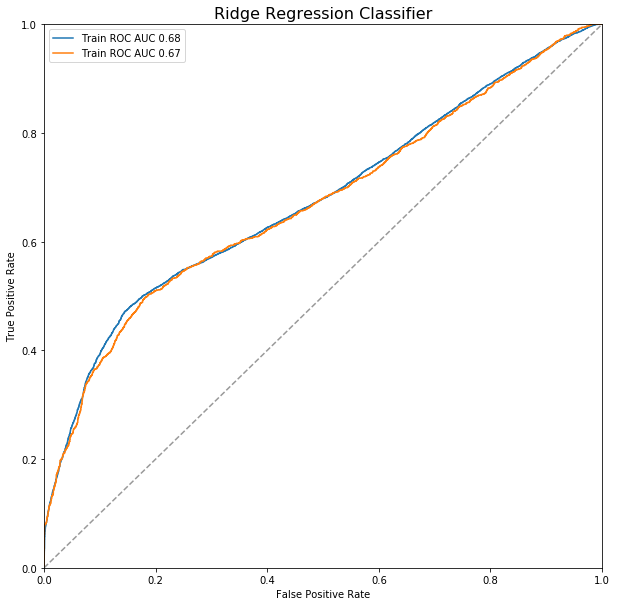

In [36]:
rg = Ridge(alpha=500).fit(X=X_train, y=y_train)

y_train_predict = rg.predict(X_train)
y_test_predict = rg.predict(X_test)
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Train ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ridge Regression Classifier', size=16)
plt.legend(loc='upper left')
plt.show()

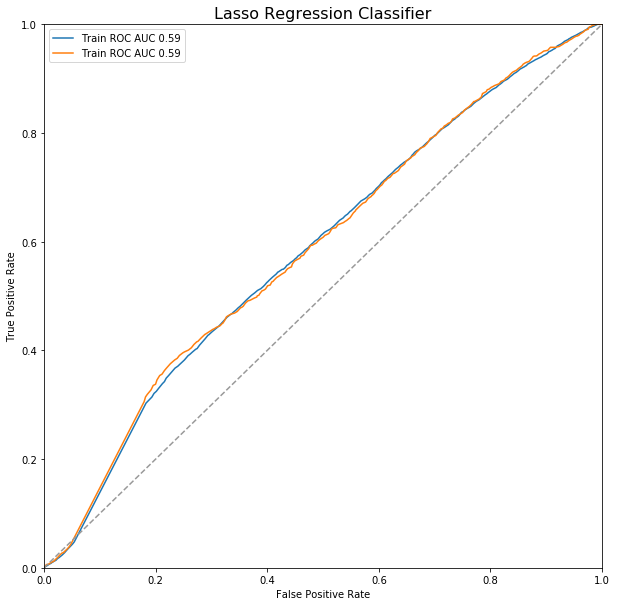

In [37]:
ls = Lasso().fit(X=X_train, y=y_train)

y_train_predict = ls.predict(X_train)
y_test_predict = ls.predict(X_test)
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Train ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lasso Regression Classifier', size=16)
plt.legend(loc='upper left')
plt.show()

Изучим результаты работы разных алгоритмов

In [38]:
model_comparison = pd.DataFrame(X_train.columns.tolist())
model_comparison.columns = ['Features']
model_comparison.index = model_comparison['Features']
model_comparison.drop(columns=['Features'], inplace=True)
model_comparison['Linear'] = lm.coef_
model_comparison['Ridge'] = rg.coef_
model_comparison['Lasso'] = ls.coef_

lm_rss = lm.score(X_train, y_train)
rg_rss = rg.score(X_train, y_train)
ls_rss = ls.score(X_train, y_train)

model_comparison.loc['RSS'] = [lm_rss, rg_rss, ls_rss]

model_comparison

,Linear,Ridge,Lasso
Features,,,
action_type,1.035340,0.514605,0.000000
combined_shot_type,-0.104630,0.126468,0.000000
loc_x,0.000058,0.000045,0.000000
loc_y,0.000211,-0.000143,-0.000705
minutes_remaining,0.608766,0.024644,0.000000
period,0.728063,0.011314,0.000000
playoffs,2.461658,-0.000004,-0.000000
season,0.935760,0.019874,0.000000
seconds_remaining,0.690815,0.036306,0.000000


Вот это интересно, и довольно логично:
- Ridge считает что тип броска и дистанция до кольца играют ключевое значение
- Lasso прекрасно понимает, что нет ничего важнее, чем расстояние до кольца
- При использовании Ridge - RSS падает. Lasso делает модель практически бесполезной.

Интересная задача!
Результаты работы закинул на кегл. С линейной регрессией я занял бы 700-ю позицию из 1117.

Думаю, неплохо для первого раза.